<a href="https://colab.research.google.com/github/LeeDongGeon1996/TensorFlow-study-note/blob/master/my-practice/Experiment_07_Generate_MNIST_dataset_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment_07_Generate_MNIST_dataset_using_GAN



In [1]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
drive.mount('/content/drive')

print(tf.__version__)
print(keras.__version__)

learning_rate = 0.0005
training_epochs = 1
batch_size = 100

mnist = keras.datasets.mnist

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
2.2.0-rc1
2.2.4-tf


In [0]:
class GAN(keras.models.Sequential):
  def __init__(self, epoch, gen=None, disc=None, start_epoch=0):
    super().__init__()

    self.epochs = epoch
    self.start_epoch = start_epoch
    self.cur_epoch = start_epoch

    if gen is None:
      self.generator = self.create_generator()
    else:
      self.generator = gen

    if disc is None:
      self.discriminator = self.create_discriminator()
    else:
      self.discriminator = disc
      
    self.compile_all()

  def save_model(self):
    gen_name = '/content/drive/My Drive/Colab Notebooks/GAN_mnist/20200330_GAN_MNIST_gen_{}.h5'.format(self.cur_epoch)
    disc_name = '/content/drive/My Drive/Colab Notebooks/GAN_mnist/20200330_GAN_MNIST_disc_{}.h5'.format(self.cur_epoch)
    self.generator.save(gen_name)
    self.discriminator.save(disc_name)
    print('generator % discriminator have been saved\n{}\n{}'.format(gen_name, disc_name))

  def compile_all(self):
    opt_G = keras.optimizers.SGD(learning_rate=0.005, momentum=0.9, nesterov=True)
    opt_D = keras.optimizers.SGD(learning_rate=0.0005, momentum=0.9, nesterov=True)

    #compile entire network
    self.add(self.generator)
    self.discriminator.trainable = False
    self.add(self.discriminator)

    self.compile(loss='binary_crossentropy', optimizer=opt_G)

    #compile disc network
    self.discriminator.trainable = True
    self.discriminator.compile(loss='binary_crossentropy', optimizer=opt_D)
    
  def create_generator(self):
    activation_func = 'tanh'
 
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=256, activation=activation_func, input_dim=784))
    model.add(keras.layers.Dense(units=512, activation=activation_func))
    model.add(keras.layers.Dense(units=1024, activation=activation_func))
    #avoid overfitting
    model.add(layers.BatchNormalization())
    model.add(keras.layers.Dense(units=784, activation=tf.nn.sigmoid))
    model.add(keras.layers.Reshape((28,28,1)))
    #model.add(keras.layers.Activation(self.change_dims))
    return model

  def normalization(self,x):
    return (x+1.)/2

  def get_generator(self):
    generator = keras.models.Sequential()
    generator.add(keras.layers.Dense(256, input_dim=784))
    generator.add(keras.layers.LeakyReLU(0.2))

    generator.add(keras.layers.Dense(512))
    generator.add(keras.layers.LeakyReLU(0.2))

    generator.add(keras.layers.Dense(1024))
    generator.add(keras.layers.LeakyReLU(0.2))

    generator.add(keras.layers.Dense(784, activation='tanh'))
    generator.add(keras.layers.Activation(self.normalization))
    generator.add(keras.layers.Reshape((28,28,1)))
    return generator

  def create_discriminator(self):
    model = keras.models.Sequential()
    #model.add(keras.layers.Activation(self.expand_dim))
    model.add(keras.layers.Conv2D(filters=32, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=64, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Conv2D(filters=128, kernel_size=[3, 3], padding='SAME', activation=tf.nn.relu))
    model.add(keras.layers.MaxPool2D(padding='SAME'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=256, activation=tf.nn.relu))
    model.add(keras.layers.Dropout(rate=0.4))
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model

  def _create_noise(self, length):
    return tf.random.uniform((length, 784), -1., 1.)


  def _get_mnist(self, batch_size):
    (train_images, train_labels), (test_images, test_labels) = mnist.load_data()    
    train_images = train_images.astype('float32') / 255.
    test_images = test_images.astype('float32') / 255.

    return train_images, test_images

  def _get_acc(self, pred_y, real_y):
    pred_y = tf.cast(pred_y>0.5, dtype=tf.float32)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(pred_y, real_y), dtype=tf.float32))
    return accuracy

  def _train_once(self, x):
    length = x.shape[0]
    validation_batch_size = int(length/50)
    validation_noise = self._create_noise(validation_batch_size)
    

    target_acc = 0.35
    disc_cnt = 0
    gen_cnt = 0

    cur_acc = 0.3
    y_data = [1]*length + [0]*length
    y_data = tf.convert_to_tensor(y_data)
    
    while((cur_acc > 0.2) and (cur_acc<0.4)):
      noise_images = self._create_noise(length)
      fake_images = self.generator.predict(noise_images, verbose=0)

      fake_images = tf.reshape(fake_images, (length, 28, 28))
      x_data = tf.concat([x, fake_images],0)
      x_data = tf.reshape(x_data, (x_data.shape[0], 28, 28, 1))

      loss_D = self.discriminator.train_on_batch(x_data, y_data)
        
      validation_fake_image = self.generator.predict(validation_noise, verbose=0)
      disc_pred_y = self.discriminator.predict(validation_fake_image, verbose=0)
      cur_acc = self._get_acc(disc_pred_y, [0]*validation_batch_size)
      #print('dis_training with : {}'.format(cur_acc))
      disc_cnt += 1

    disc_acc = cur_acc

    self.discriminator.trainable = False
    #discriminator true로 인식하도록 해야한다.
    length_twice = length
    cur_acc = 0.3
    y_data = [1]*length_twice
    y_data = tf.convert_to_tensor(y_data)

    while((cur_acc > 0.2) and (cur_acc<0.4)):
      x_data = self._create_noise(length_twice)
      loss_G = self.train_on_batch(x_data, y_data)
      gen_pred_y = self.predict(validation_noise, verbose=0)
      cur_acc = self._get_acc(gen_pred_y, [1]*validation_batch_size)
      #print('gen_training with : {}'.format(cur_acc))
      gen_cnt += 1

    gen_acc = cur_acc

    self.discriminator.trainable = True

    return loss_G, loss_D, disc_acc, gen_acc, disc_cnt, gen_cnt

  def get_x(self, x_train, index, batch_size):
    return x_train[index * batch_size:(index + 1) * batch_size]

  def _show_image(self, image):

    plt.figure(figsize=(10, 5))
    for i in range(int(image.shape[0])):

      plt.subplot(2,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(image[i], cmap='gray_r')
    plt.show()


  def train(self):
    epochs = self.epochs
    batch_size = 300

    train_images, test_images = self._get_mnist(batch_size)

    for epoch in range(self.start_epoch, epochs):
      self.cur_epoch = epoch
      for index in range(int(train_images.shape[0] / batch_size)):
        loss_G, loss_D, disc_acc, gen_acc, disc_cnt, gen_cnt = self._train_once(self.get_x(train_images, index, batch_size))

      if (epoch%1 == 0) or (epoch == epochs-1):
        print('epoch[' + str(self.cur_epoch) + '] loss_G : ' + str(loss_G) + ', loss_D : ' + str(loss_D) + ', disc_acc({}) : {}'.format(disc_cnt, disc_acc) + ', gen_acc({}) : {}'.format(gen_cnt,gen_acc)) 
        
      if (epoch%5 == 0) or (epoch == epochs-1):
        create_num = 10
        created_image = self.generator.predict(self._create_noise(create_num))
        created_image = tf.reshape(created_image, (create_num, 28, 28))
        created_image = created_image*255
        self._show_image(created_image)

      if (epoch%30 == 0) or (epoch == epochs-1):
        self.save_model()
    

epoch[481] loss_G : 1.390421986579895, loss_D : 0.40703099966049194, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[482] loss_G : 1.3539577722549438, loss_D : 0.3896096646785736, disc_acc(1) : 0.8333333134651184, gen_acc(1) : 0.1666666716337204
epoch[483] loss_G : 1.3509279489517212, loss_D : 0.3686274588108063, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[484] loss_G : 1.4778190851211548, loss_D : 0.38938289880752563, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[485] loss_G : 1.3166509866714478, loss_D : 0.3986201584339142, disc_acc(1) : 1.0, gen_acc(1) : 0.0


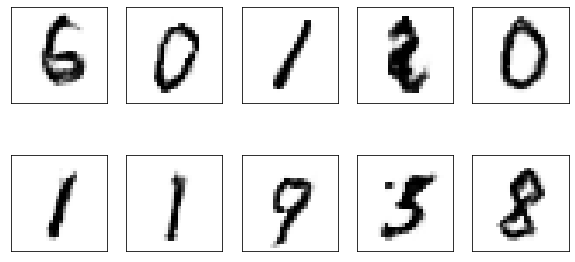

epoch[486] loss_G : 1.3638036251068115, loss_D : 0.3968520164489746, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[487] loss_G : 1.3485546112060547, loss_D : 0.3734438419342041, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[488] loss_G : 1.389784336090088, loss_D : 0.31570684909820557, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[489] loss_G : 1.4707845449447632, loss_D : 0.32388997077941895, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[490] loss_G : 1.4068944454193115, loss_D : 0.3653991222381592, disc_acc(1) : 1.0, gen_acc(1) : 0.0


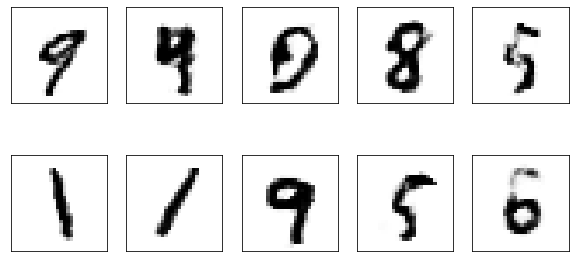

epoch[491] loss_G : 1.4847804307937622, loss_D : 0.3421401083469391, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[492] loss_G : 1.3935903310775757, loss_D : 0.3645520508289337, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[493] loss_G : 1.3702467679977417, loss_D : 0.40555116534233093, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[494] loss_G : 1.4590778350830078, loss_D : 0.36622539162635803, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[495] loss_G : 1.2804956436157227, loss_D : 0.4140626788139343, disc_acc(1) : 0.8333333134651184, gen_acc(1) : 0.1666666716337204


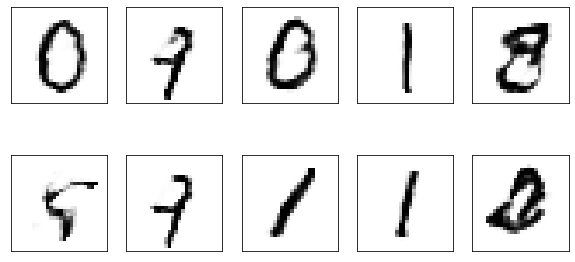

epoch[496] loss_G : 1.3037289381027222, loss_D : 0.38935306668281555, disc_acc(1) : 0.8333333134651184, gen_acc(1) : 0.1666666716337204
epoch[497] loss_G : 1.4169715642929077, loss_D : 0.41328853368759155, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[498] loss_G : 1.292716383934021, loss_D : 0.38956788182258606, disc_acc(1) : 0.8333333134651184, gen_acc(1) : 0.1666666716337204
epoch[499] loss_G : 1.3321441411972046, loss_D : 0.41526317596435547, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[500] loss_G : 1.3183884620666504, loss_D : 0.5238423943519592, disc_acc(1) : 1.0, gen_acc(1) : 0.0


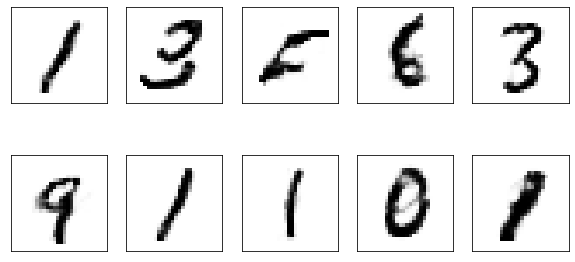

epoch[501] loss_G : 1.310579776763916, loss_D : 0.42054128646850586, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[502] loss_G : 1.1761040687561035, loss_D : 0.44567036628723145, disc_acc(1) : 0.6666666865348816, gen_acc(10) : 0.5
epoch[503] loss_G : 1.2644374370574951, loss_D : 0.43194523453712463, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[504] loss_G : 1.2932747602462769, loss_D : 0.38716283440589905, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[505] loss_G : 1.3315640687942505, loss_D : 0.4044802188873291, disc_acc(1) : 1.0, gen_acc(1) : 0.0


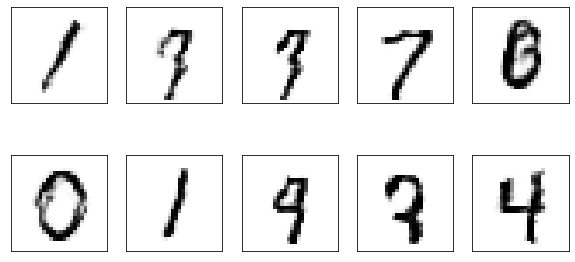

epoch[506] loss_G : 1.2654825448989868, loss_D : 0.4231327176094055, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[507] loss_G : 1.2413264513015747, loss_D : 0.3822726607322693, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[508] loss_G : 1.1239148378372192, loss_D : 0.39686083793640137, disc_acc(1) : 0.6666666865348816, gen_acc(20) : 0.1666666716337204
epoch[509] loss_G : 1.444858431816101, loss_D : 0.42870253324508667, disc_acc(1) : 0.8333333134651184, gen_acc(1) : 0.1666666716337204
epoch[510] loss_G : 1.3797261714935303, loss_D : 0.38136133551597595, disc_acc(1) : 0.8333333134651184, gen_acc(1) : 0.1666666716337204


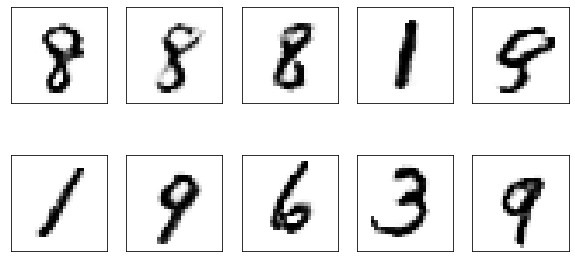

generator % discriminator have been saved
/content/drive/My Drive/Colab Notebooks/GAN_mnist/20200330_GAN_MNIST_gen_510.h5
/content/drive/My Drive/Colab Notebooks/GAN_mnist/20200330_GAN_MNIST_disc_510.h5
epoch[511] loss_G : 1.2889809608459473, loss_D : 0.4071168899536133, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[512] loss_G : 1.333703637123108, loss_D : 0.38659003376960754, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[513] loss_G : 1.3430733680725098, loss_D : 0.4588736593723297, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[514] loss_G : 1.211120843887329, loss_D : 0.402404248714447, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[515] loss_G : 1.3724209070205688, loss_D : 0.3892052173614502, disc_acc(1) : 1.0, gen_acc(1) : 0.0


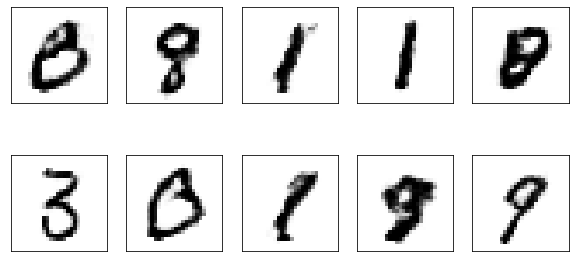

epoch[516] loss_G : 1.2983351945877075, loss_D : 0.4491980969905853, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[517] loss_G : 1.3206039667129517, loss_D : 0.36193111538887024, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[518] loss_G : 1.3552478551864624, loss_D : 0.4198629856109619, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[519] loss_G : 1.2754464149475098, loss_D : 0.4585879445075989, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[520] loss_G : 1.3240838050842285, loss_D : 0.38241222500801086, disc_acc(1) : 1.0, gen_acc(1) : 0.0


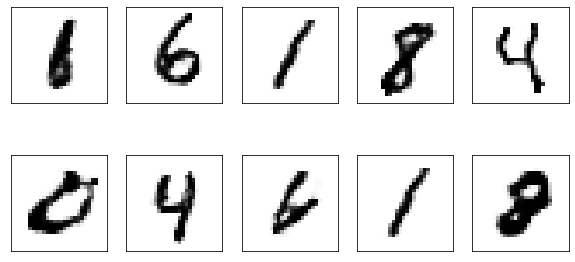

epoch[521] loss_G : 1.3548067808151245, loss_D : 0.41083791851997375, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[522] loss_G : 1.3167568445205688, loss_D : 0.36375465989112854, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[523] loss_G : 1.3813304901123047, loss_D : 0.3636666238307953, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[524] loss_G : 1.3979359865188599, loss_D : 0.4903799295425415, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[525] loss_G : 1.3311253786087036, loss_D : 0.3703073263168335, disc_acc(1) : 1.0, gen_acc(1) : 0.0


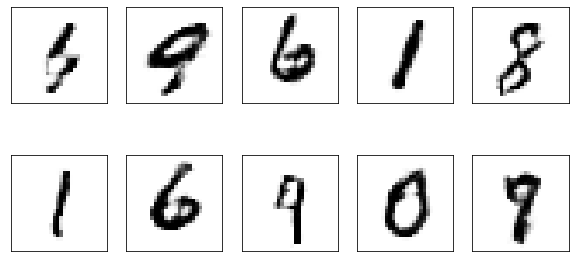

epoch[526] loss_G : 1.2563092708587646, loss_D : 0.4413830041885376, disc_acc(1) : 0.8333333134651184, gen_acc(1) : 0.1666666716337204
epoch[527] loss_G : 1.3327651023864746, loss_D : 0.3846854567527771, disc_acc(1) : 0.8333333134651184, gen_acc(1) : 0.1666666716337204
epoch[528] loss_G : 1.3142828941345215, loss_D : 0.39465945959091187, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[529] loss_G : 1.2675782442092896, loss_D : 0.4783587157726288, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[530] loss_G : 1.3838603496551514, loss_D : 0.45346975326538086, disc_acc(1) : 1.0, gen_acc(1) : 0.0


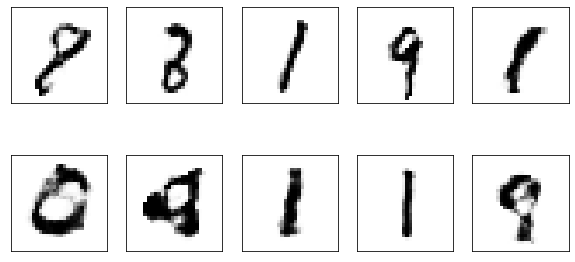

epoch[531] loss_G : 1.428294062614441, loss_D : 0.3945387005805969, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[532] loss_G : 1.375977635383606, loss_D : 0.3674044609069824, disc_acc(1) : 0.8333333134651184, gen_acc(1) : 0.1666666716337204
epoch[533] loss_G : 1.2900563478469849, loss_D : 0.4786602854728699, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[534] loss_G : 1.2422654628753662, loss_D : 0.4877912998199463, disc_acc(1) : 0.8333333134651184, gen_acc(1) : 0.1666666716337204
epoch[535] loss_G : 1.3970850706100464, loss_D : 0.4566117227077484, disc_acc(1) : 1.0, gen_acc(1) : 0.0


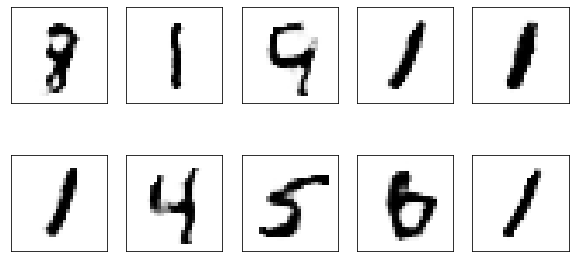

epoch[536] loss_G : 1.2742477655410767, loss_D : 0.4040704071521759, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[537] loss_G : 1.2769255638122559, loss_D : 0.4245707392692566, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[538] loss_G : 1.2767513990402222, loss_D : 0.4005996882915497, disc_acc(1) : 1.0, gen_acc(1) : 0.0
epoch[539] loss_G : 1.2707009315490723, loss_D : 0.4418908655643463, disc_acc(1) : 1.0, gen_acc(1) : 0.0


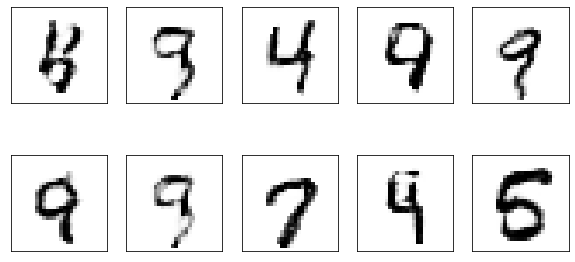

generator % discriminator have been saved
/content/drive/My Drive/Colab Notebooks/GAN_mnist/20200330_GAN_MNIST_gen_539.h5
/content/drive/My Drive/Colab Notebooks/GAN_mnist/20200330_GAN_MNIST_disc_539.h5


In [6]:
gen = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/GAN_mnist/20200330_GAN_MNIST_gen_480.h5')
disc = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/GAN_mnist/20200330_GAN_MNIST_disc_480.h5')

gan = GAN(epoch=540, gen=gen, disc=disc, start_epoch=481)
gan.train()

In [0]:
gan = GAN(epoch=500)
gan.train()

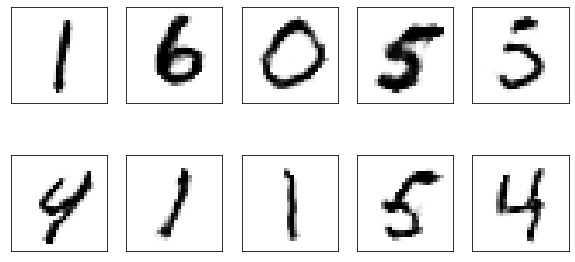

In [25]:
create_num=10
created_image = gan.generator.predict(gan._create_noise(create_num))
created_image = tf.reshape(created_image, (create_num, 28, 28))
created_image = created_image*255
gan._show_image(created_image)

